# translating matlab code parser

## setup

In [25]:
from pathlib import Path
import numpy as np
import time

from tqdm import tqdm_notebook

## params

In [2]:
# paths
lvm_path = Path(r'data/qim_20kbps_10db_l2_v2.lvm')

# signal specific params
spb = 20
header = [0 if i % 2 == 0 else 1 for i in range(10)]
print(f'header: {header}')

header: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


## class building

In [101]:
class DataParserLVM:
    def __init__(self, lvm_path, spb, header=None):
        print('initializing..')
        
        # set input path
        if isinstance(lvm_path, Path):
            try: 
                assert lvm_path.exists()
                self.lvm_path = lvm_path
                print(f'\tset input lvm path: {self.lvm_path}')
            except AssertionError:
                print(f'no file found at {lvm_path}')
                raise                
        else:
            print(f'invalid path {lvm_path}, must be pathlib.Path object')
            raise TypeError
        
        # samples per bit
        try:
            assert isinstance(spb, int)
            self.spb = spb
            print(f'\tset samples per bit: {self.spb}')
        except AssertionError:
            try:
                self.spb = int(spb)
                print(f'\tset samples per bit: {self.spb}')
            except Exception:
                print(
                    f'unable to convert provided spb ({type(spb)}) to integer, ' + 
                    f'please provide in integer format'
                )
                raise
                
        # header
        if header is None:
            self.header = np.array([0 if i % 2 == 0 else 1 for i in range(10)])
            print(f'\tset header: {self.header}')
        else:
            if isinstance(header, list):
                self.header = np.array(header)
                print(f'\tset header: {self.header}')
            elif isinstance(header, np.array):
                self.header = header
                print(f'\tset header: {self.header}')
            else:
                print(
                    f'invalid header format specified ({type(header)}), ' + 
                    f'must be np.array or list'
                )
                raise TypeError
                
        # startup tasks
        self.parse_lvm_file()
        self.read_csv_data()
        self.preprocess_data()
        
            
    def parse_lvm_file(self, output_path='auto'):
        """
        reads in .lvm file, writes out .csv with column names
        containing only data points
        
        [arguments]
        input_path: str or pathlib.Path object (preferred)
            input file path
        output_path: 'auto' (preferred) or str or pathlib.Path object
            if auto:
                appends _parsed.csv to end of input file name
            else:
                use provided path, must end in .csv
                
        [returns]
        None
            outputs parsed lvm file
            sets self.parsed_lvm_path, pathlib.Path object pointing to parsed file
        """
        
        print('parsing lvm file..')
        with open(self.lvm_path, 'r') as infile:
            # set output path
            file_name = infile.name
            
            if output_path == 'auto':
                self.parsed_lvm_path = Path(f'{file_name}_parsed.csv')
            else:
                self.parsed_lvm_path = output_path
                
                if isinstance(parsed_lvm_path, Path):
                    try:
                        assert str(parsed_lvm_path).endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                elif isinstance(parsed_lvm_path, str):
                    try:
                        assert parsed_lvm_path.endswith('.csv')
                    except AssertionError:
                        print('output file must end with .csv')
                        raise
                else:
                    print('error, output_path must be str or pathlib.Path object')
                    raise TypeError
            
            if not self.parsed_lvm_path.exists():
                self.parsed_lvm_path.touch()
            
            # find header, store column names
            while True:
                line = infile.readline()
                
                if line.strip().endswith('Comment'):
                    cols = line.split(',')[:-1]
                    print(f'\tcolumns: {cols}')
                    break        
                    
            # trim file and write out
            with open(self.parsed_lvm_path, 'w') as outfile:
                outfile.write(', '.join(cols) + '\n')
                while True:
                    try:
                        outfile.write(next(infile))
                    except StopIteration:
                        break
        
        print(f'\tcomplete, parsed file saved to: {self.parsed_lvm_path}')
        
    def read_csv_data(self):
        print('importing data from parsed csv..')
        self.raw_data = np.genfromtxt(
            self.parsed_lvm_path,
            delimiter=',',
            skip_header=1,
            usecols=(1)
        )
        
        print(f'\timported data, {self.raw_data.size} rows')
        
        
    def preprocess_data(self):
        th = max(self.raw_data) / 2
        shape_check = self.raw_data[np.where(self.raw_data >= th)].size
        
        self.raw_data[np.where(self.raw_data >= th)] = 1
        self.raw_data[np.where(self.raw_data < th)] = 0
        
        # set dtype and store
        self.data = self.raw_data.astype('int')
        
        # validate
        try:
            assert self.data.sum() == shape_check            
        except AssertionError:
            print(
                f'error: sum of 1\'s ({self.data.sum()}) does not match ' + 
                f'number of entries >= th ({shape_check})'
            )
        
        
    def get_state_length_list(self, data):
        '''
        takes data list ([1,1,0,1,0,0,...]) and returns numpy array 
        of duration of consecutive bits ([13,245,2588,19,1056,...])
        '''
        
        return np.diff(
            np.where(
                np.concatenate(
                    ([data[0]],
                     data[:-1] != data[1:],
                     [0]
                    )
                )
            )[0]
        )[::2]
    

    def discretize_signal(self):
        start_time = time.time()
        print('discretizing signal..')
        
        # set params
        discretized_data = []
        start_bit = self.data[0]
        alt_bit = 0 if start_bit == 1 else 1
        print(f'\tstarting bit: {start_bit}, alt bit: {alt_bit}')
        
        # get state lengths
        state_lengths = self.get_state_length_list(self.data)
        
        for i, state in enumerate(state_lengths):
            discretized_state = int(np.round(state / self.spb))
            #print(f'iter: {i}, discretized state: {discretized_state}')
            
            if i % 2 == 0:
                discretized_data.append([start_bit for j in range(discretized_state)])
            elif i % 2 == 1:
                discretized_data.append([alt_bit for j in range(discretized_state)])
            else:
                print('ya done messed up.')
        
        self.discretized_array = np.array([
            item for sublist 
                in discretized_data 
            for item in sublist
        ])
        
        reduction = 100 * (self.discretized_array.size / self.data.size)
        print(
            f'\tcomplete, discretized signal: {self.discretized_array.size} entries ' + 
            f'({reduction:0.2f}% of original)\n'
            f'\tprocessing time: {time.time() - start_time:0.4f} sec, hot damn.'
        )
        

    def search_sequence_numpy(self, arr, seq):
        """ 
        find sequence in an array 
    
        Parameters
        ----------    
        arr    : input 1D array
        seq    : input 1D array
    
        Output
        ------    
        Output : 1D Array of indices in the input array that satisfy the 
        matching of input sequence in the input array.
        In case of no match, an empty list is returned.
        """
    
        # Store sizes of input array and sequence
        Na, Nseq = arr.size, seq.size
    
        # Range of sequence
        r_seq = np.arange(Nseq)
    
        # Create a 2D array of sliding indices across the entire length of input array.
        # Match up with the input sequence & get the matching starting indices.
        M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)
    
        # Get the range of those indices as final output
        if M.any() >0:
            return np.where(
                np.convolve(
                    M,
                    np.ones((Nseq), dtype=int)
                ) > 0
            )[0]
        else:
            return []  
        
    
    def output_discretized_array(self, output_path='auto', output_format='csv'):
        # set output path
        if output_path == 'auto':
            output_path = Path(r'data/discretized_array.csv')            
        elif isinstance(output_path, Path):
            try:
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        elif isinstance(output_path, str):
            try:
                output_path = Path(output_path)
                assert output_path.parent.exists()
                assert output_path.name.endswith('.csv')
            except AssertionError:
                print(
                    f'parent path ({output_path.parent}) unavailable or ' + 
                    f'path does not end with .csv ({output_path.name}), ' + 
                    f'please choose another path'
                )
                raise
        else:
            print(
                f'you really messed up, you provided {output_path} {type(output_path)}, ' + 
                f'please provide output_path as str or pathlib.Path object ending with .csv'
            )            
        print(f'set discretized signal output path: {output_path}')
                
        # output
        if output_format == 'csv':
            np.savetxt(
                output_path,
                self.discretized_array,
                delimiter=','
            )
            print(f'\tsuccessfully saved file to: {output_path}')
        else:
            print(f'yeah.. csv is actually the only option.. please try again.')
            raise TypeError
    
    
    
    def main(self):
        self.discretize_signal()
        
        
        

In [102]:
DP = DataParserLVM(lvm_path, 92)

initializing..
	set input lvm path: data\qim_20kbps_10db_l2_v2.lvm
	set samples per bit: 92
	set header: [0 1 0 1 0 1 0 1 0 1]
parsing lvm file..
	columns: ['X_Value', 'Voltage']
	complete, parsed file saved to: data\qim_20kbps_10db_l2_v2.lvm_parsed.csv
importing data from parsed csv..
	imported data, 4000000 rows


In [103]:
DP.discretize_signal()

discretizing signal..
	starting bit: 0, alt bit: 1
	complete, discretized signal: 16035 entries (0.40% of original)
	processing time: 0.2640 sec, hot damn.


In [104]:
DP.output_discretized_array()

set discretized signal output path: data\discretized_array.csv


In [107]:
DP.discretized_array

array([0, 1, 0, ..., 0, 0, 1])

## visualiziation 

In [40]:
# seaborn with custom background
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',rc={'figure.facecolor':'#abb2bf'})

### discretized vs real

In [90]:
def compare_plots(start, stop):
    fig, ((ax1, ax2)) = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(20,12))
    
    ax1.stem(DP.raw_data[start*DP.spb:stop*DP.spb])
    ax2.stem(DP.discretized_array[start:stop])    
    

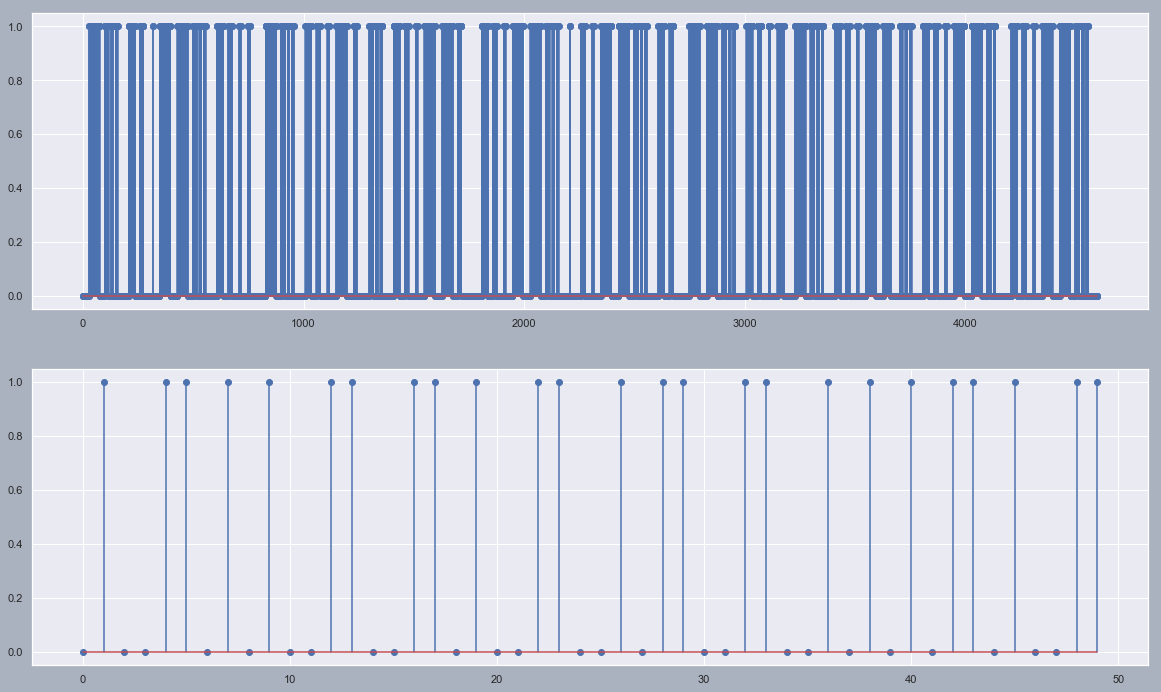

In [91]:
compare_plots(0, 50)

In [79]:
start = 1000
stop = 1060

In [ ]:
plt.figure(figsize=(20,6))
plt.stem(DP.raw_data[start*DP.spb:stop*DP.spb])

In [ ]:
plt.figure(figsize=(20,6))
plt.stem(DP.discretized_array[start:stop])

### spb brute force attempt

In [11]:
from collections import Counter

In [12]:
spb_list = [i for i in range(90, 100, 1)]
print(f'spb_list: {len(spb_list)} elements')

spb_list: 10 elements


In [21]:
result_dict = {}

for spb in tqdm_notebook(spb_list):
    discretized_array = discretize_signal(DP.raw_data, spb)    
    
    result_dict[spb] = search_sequence_numpy(discretized_array, np.array(header))

In [22]:
frequencies = {
    spb: Counter(np.diff(matches)).most_common(3)
    for spb, matches in result_dict.items()
}

frequencies[90]

[(1, 807), (191, 38), (192, 21)]

In [23]:
frequencies

{90: [(1, 807), (191, 38), (192, 21)],
 91: [(1, 807), (191, 38), (192, 21)],
 92: [(1, 807), (190, 69), (191, 2)],
 93: [(1, 807), (190, 69), (191, 2)],
 94: [(1, 798), (189, 37), (188, 18)],
 95: [(1, 798), (189, 37), (188, 18)],
 96: [(1, 783), (188, 56), (187, 8)],
 97: [(1, 783), (188, 56), (187, 8)],
 98: [(1, 397), (41, 2), (98, 1)],
 99: [(1, 397), (41, 2), (98, 1)]}